In [1]:
import cvxpy as cp
import numpy as np
from techtile_tools import K, M, get_d_MK, get_L_MK
import matplotlib.pyplot as plt
import tikzplotlib
import os

file_dir = os.path.join(os.path.abspath(''), "..",
                        "figures", "techtile", "coherent")

Found 84 antennas


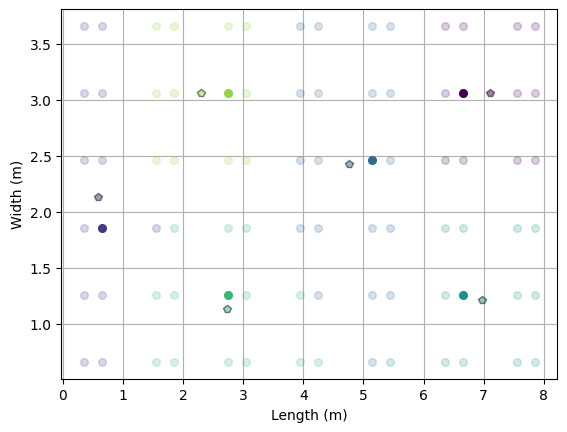

In [2]:
# numerical threshold
NUM_TH = 1e-13
# Define parameters
# K = 10
# M = 100

N = M  # define the same number of time slots as number of antennas

E = 500  # mJ
fc = 0.917  # in GHz
alpha = 0.16145203
beta = 0.0158  # mW
Pmax = 1000  # mW


M_vals = np.arange(2, M+1, 1)

L_MMK = get_L_MK(M_vals)
h_MMK = []

T_M = [12*60*60/vM for vM in M_vals]


for vM, L_MK in zip(M_vals, L_MMK):
    h_MMK.append(np.sqrt(L_MK) * np.exp(1j*np.random.uniform(0, 2 * np.pi, (vM,K))))

In [3]:
def get_Ws(X, alpha, _T):
    """ Get the precoding weight W_s from the X matrix, alpha and T

    Args:
        X (M by M matrix): optimal X
        alpha (scalar): harvester efficiency
        T (scalar): time slot duration in seconds

    Returns:
        Precoding matrix (MxS matrix)
    """
    eigenvalues, eigenvectors = np.linalg.eigh(X)

    # Handle numerical errors where eigenvalues might be close to zero but negative due to precision issues
    eigenvalues[eigenvalues < NUM_TH] = 0

    W = np.dot(eigenvectors, np.diag(np.sqrt(eigenvalues)))

    pos_idxs = eigenvalues > 0

    return W[:, pos_idxs] / np.sqrt(alpha*_T)

In [4]:
def check_constraint(h_MK, Ws_MS, _T, _N):
    _, S = np.shape(Ws_MS)
    met = True
    for k in range(K):
        rx_E = 0
        for s in range(S):
            rx_E += _T*alpha*np.abs(np.sum(h_MK[:, k]*Ws_MS[:, s]))**2
        if rx_E+0.01 < E + _N*_T*beta:
            met = False
            print(
                f"Not enough RX energy for ESL {k} {rx_E:.4f}<{E + _N*_T*beta:.4f}")

    return met

Below is the optimization problem:
$$ 
\min_{\mathrm{X}  \succeq  0} \mathrm{tr}[\mathrm{X}]  \text{ s.t. } \mathrm{tr}\left[\mathrm{G}_k\mathrm{X}\right]  \geq E + NT\beta,\ \forall k.
$$

In [5]:
X_vals = [0]*len(M_vals)
Ws_vals = [0]*len(M_vals)

for iM, vM in enumerate(M_vals):

    # Define the variables

    X = cp.Variable((vM, vM), hermitian=True)  # X is symmetric

    # Define the optimization problem

    objective = cp.Minimize(cp.real(cp.trace(X)))

    constraints = [X >> 0]  # X is positive semidefinite

    G = np.zeros((K, vM, vM), dtype=complex)

    h_MK = h_MMK[iM]
    _N = vM
    _T = T_M[iM]

    for k in range(K):

        h_k = np.atleast_2d(h_MK[:, k])

        # Construct the Hermitian matrix G_k from h_k


        G_k = np.conj(h_k).T@h_k

        G[k, :, :] = G_k

        # due to numerical errors, the trace is not real

        # only keep real part when imag is below a threshold

        # G_k = np.where(np.imag(G_k) < NUM_TH, np.real(G_k), G_k)


        # ensure it is real, we need to check later if this does not result in errors as the imag can be anything.

        constraints += [cp.real(cp.trace(G_k @ X)) >=
                        E + _N*_T*beta]  # Constraint


    # Formulate the problem and solve it

    problem = cp.Problem(objective, constraints)

    problem.solve()

    # check if constraints are met

    num_unmet = 0

    for k in range(K):

        constraint_met = np.real( 
            np.trace(G[k, :, :] @ X.value))+0.01 >= E + _N*_T*beta  # added 0.01 for nuymercial precision. we can be off by 0.01mJ

        if not constraint_met:

            num_unmet += 1
        print(constraint_met)
    print(num_unmet)


    assert problem.status not in ["infeasible",
                                  "unbounded"], "Problem is infeasible"


    Ws_MS = get_Ws(X.value, alpha, _T)

    X_vals[iM] = X.value

    Ws_vals[iM] = Ws_MS

    _, S = Ws_MS.shape

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Check if X can be reconstructed from $W_s$
$$\mathrm{X} = (\alpha T) \sum_{n=0}^{N-1} \mathrm{w}_s \mathrm{w}_s^H \in \mathbb{C}^{M\times M}$$

In [6]:
for Ws_MS, X_val, _T in zip(Ws_vals, X_vals, T_M):
    _, S = Ws_MS.shape
    

    X_mat = alpha*_T * \
        np.sum([np.outer(Ws_MS[:, s], np.conj(Ws_MS[:, s]))
            for s in range(S)], axis=0)

    if np.allclose(X_mat, X_val):
        pass
    else:
        print("X cannot be reconstructed from Ws")

Check if the constraints are met for all $k$ users:
 - (constr_1) $\mathrm{tr}\left[\mathrm{G}_k\mathrm{X}\right]  \geq E + NT\beta,\ \forall k$
 - (constr_2) $\sum_{n=0}^{N-1} T\alpha |\mathrm{h}_k^T\mathrm{w}_n|^2 \geq E + NT\beta,\ \forall k$

 both should be the same.

 Small note ´constr_2´ is no longer $\mathrm{w}_n$ but $\mathrm{w}_s$.

In [7]:
# for k in range(K):
#     constr_1 = np.real(np.trace(G[k, :, :] @ X.value))
#     constr_2 = np.sum([(alpha*T) * np.abs(np.inner(h_MK[:, k],
#                       Ws_MS[:, s]))**2 for s in range(S)], axis=0)
#     if np.abs(constr_1-constr_2) > 1e-3:
#         print(f"Both constraints are not the same :'( {constr_2-constr_1}")

In [8]:

rx_pwr_MKS = [0]*len(M_vals)




rx_energy_KS = np.zeros((len(M_vals),K))


for iM, vM in enumerate(M_vals):

    Ws_MS = Ws_vals[iM]
    h_MK = h_MMK[iM]
    _T = T_M[iM]

    _, S = Ws_MS.shape

    rx_pwr_KS = np.zeros((K, S))

    for k in range(K):
        rx_pwr_KS[k, :] = [
            alpha * np.abs(np.inner(h_MK[:, k], Ws_MS[:, s]))**2 for s in range(S)]
        rx_energy_KS[iM, k] = np.sum(_T*rx_pwr_KS[k, :])
    rx_pwr_MKS[iM] = rx_pwr_KS

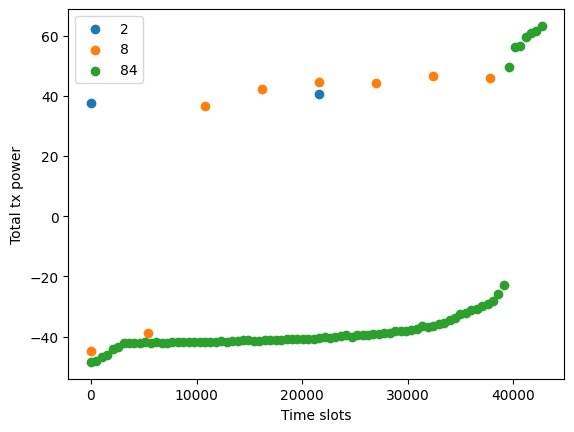

In [9]:
is_pass = [2, 8, 84]
for iM, vM in enumerate(M_vals):
    if vM not in is_pass:
        continue
    plt.scatter(np.arange(vM)*T_M[iM], 20*np.log10(np.sum(np.abs(Ws_vals[iM]), axis=0)), label=vM)

plt.ylabel("Total tx power")
plt.xlabel("Time slots")
plt.legend()

(14, 168)


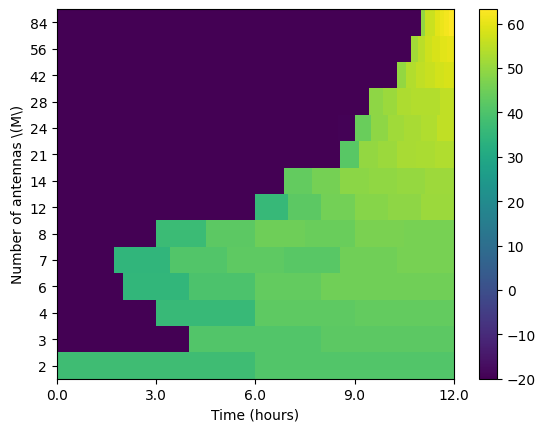

In [10]:
is_pass = [2, 8, 84]
width = int(84*2)
img = []
usedM = []
for iM, vM in enumerate(M_vals):
    if width%vM == 0:
        usedM.append(vM)

        num_repeat = width/vM
        powers = 20*np.log10(np.sum(np.abs(Ws_vals[iM]), axis=0))
        img.append(np.repeat(powers, num_repeat ))

img = np.array(img)
print(img.shape)
plt.pcolormesh(img, edgecolors='k', linewidth=0.0024, vmin=-20)
plt.xticks(ticks=np.arange(0, width+1)[::42],
           labels=((np.arange(0, width+1)/width) * 12)[::42])
plt.yticks(ticks=np.arange(0, img.shape[0])+0.5,
           labels=usedM)
plt.colorbar()
plt.ylabel("Number of antennas \(M\)")
plt.xlabel("Time (hours)")
tikzplotlib.save(os.path.join(file_dir, "tx-powers-per-N.tex"))

Text(0.5, 0, 'Number of antennas')

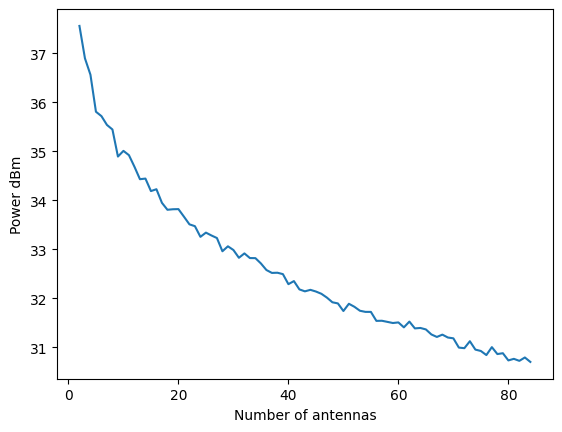

In [11]:
power_per_M = np.zeros((len(M_vals)))
for iM, vM in enumerate(M_vals):
    _T = T_M[iM]
    _N = vM
    # power_per_M[iM] = ( _T * np.sum(np.linalg.norm(np.abs(Ws_vals[iM]), axis=1)**2) )/ (_N*_T)
    power_per_M[iM] = (np.linalg.norm(Ws_vals[iM])**2 )/ _N


plt.plot(M_vals, 10*np.log10(power_per_M))


plt.ylabel("Power dBm")
plt.xlabel("Number of antennas")

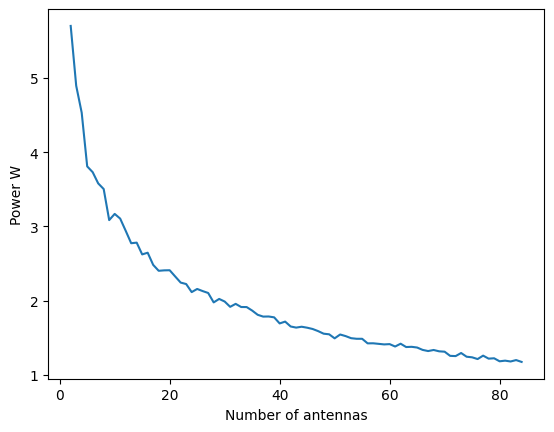

In [12]:
power_per_M = np.zeros((len(M_vals)))
for iM, vM in enumerate(M_vals):
    _T = T_M[iM]
    _N = vM
    # power_per_M[iM] = ( _T * np.sum(np.linalg.norm(np.abs(Ws_vals[iM]), axis=1)**2) )/ (_N*_T)
    power_per_M[iM] = (np.linalg.norm(Ws_vals[iM])**2 )/ _N


plt.plot(M_vals, power_per_M/1e3)

plt.ylabel("Power W")
plt.xlabel("Number of antennas")
tikzplotlib.save(os.path.join(file_dir, "tw-powers-per-M.tex"))

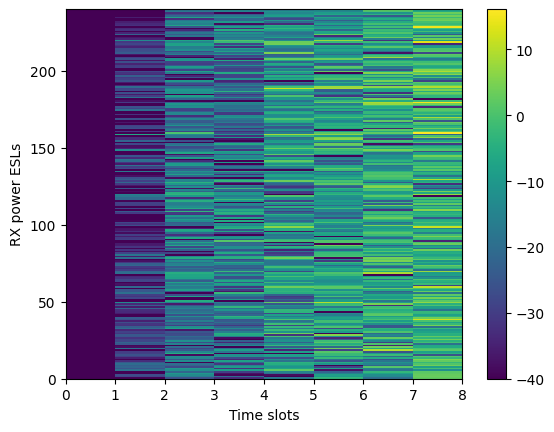

In [13]:
# plt.imshow(20*np.log10(np.abs(rx_pwr_KS))[:, 79:], aspect='auto')
START_IDX = 76
plt.pcolormesh(20*np.log10(np.abs(rx_pwr_MKS[-1]))
               [:, START_IDX:], edgecolors='k', linewidth=0.0024, vmin=-40)
plt.ylabel("RX power ESLs")
plt.xlabel("Time slots")
# plt.xticks(ticks=np.arange(0, N-START_IDX),
#            labels=np.arange(START_IDX, N))
plt.colorbar()
tikzplotlib.save(os.path.join(file_dir, "rx-powers.tex"))

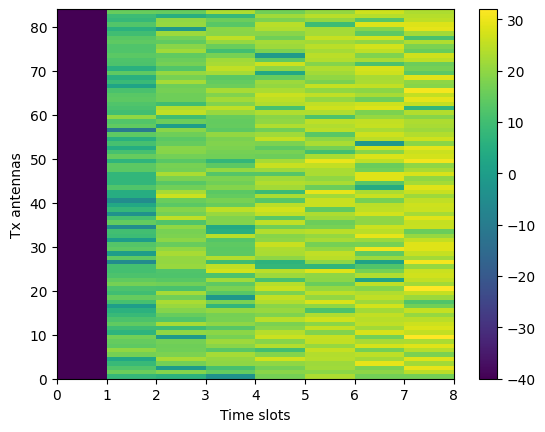

In [14]:
plt.pcolormesh(20*np.log10(np.abs(Ws_MS))
               [:, START_IDX:], shading='auto', vmin=-40)
plt.ylabel("Tx antennas")
plt.xlabel("Time slots")
plt.colorbar()
tikzplotlib.save(os.path.join(file_dir, "tx-powers.tex"))

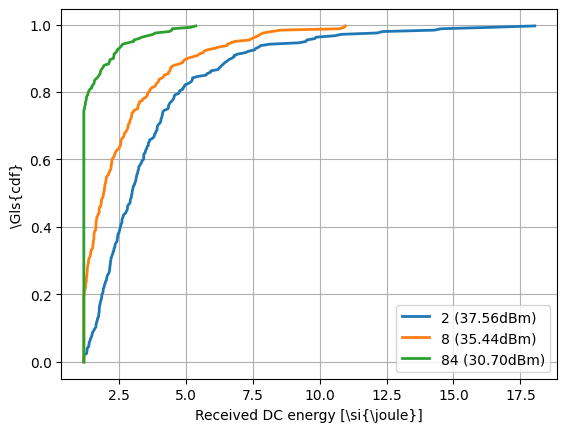

In [15]:
fig, ax = plt.subplots()
is_pass = [2, 8, 84]
for iM, vM in enumerate(M_vals):
    if vM not in is_pass:
        continue
    a = rx_energy_KS[iM]/1e3
    _N = vM
    x = np.sort(a)
    y = np.linspace(0, 1, len(a), endpoint=False)
    ax.plot(
        x, y, label=f'{vM} ({10*np.log10(np.linalg.norm(Ws_vals[iM])**2/_N):.2f}dBm)', linewidth=2)

# ax.axvline(x=(E+beta*N*T)/1.e3)

# print(E+beta*N*T)


ax.set_xlabel('Received DC energy [\si{\joule}]')
ax.set_ylabel('\Gls{cdf}')
ax.legend()
ax.grid(True)

tikzplotlib.save(os.path.join(file_dir, "cdf-dc-rx.tex"))

plt.show()